# NBA Game Predictor Model
### CMPE 257 Project
Authors: Kaushika Uppu, Miranda Billawala, Yun Ei Hlaing, Iris Cheung

## Imports

In [88]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

## NBA Game Data

First, we load in all of the NBA game data from the CSV file. Exact code for gathering data is in a separate file and use the nba_api file. Only games from the 1985-1986 season and afterward are loaded in as the seasons before that are missing a very significant portion of the game statistics' data. 

In [47]:
all_stats = pd.read_csv('all_game_stats.csv')
all_stats.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG
0,21985.0,1610612737,ATL,Atlanta Hawks,28500933,1986-04-12,ATL vs. IND,W,240.0,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21985.0,1610612737,ATL,Atlanta Hawks,28500921,1986-04-10,ATL vs. NJN,W,240.0,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21985.0,1610612737,ATL,Atlanta Hawks,28500908,1986-04-08,ATL vs. CHI,W,240.0,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21985.0,1610612737,ATL,Atlanta Hawks,28500891,1986-04-05,ATL @ CHI,L,240.0,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21985.0,1610612737,ATL,Atlanta Hawks,28500884,1986-04-04,ATL @ WAS,L,265.0,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
all_stats.shape

(89542, 59)

## Data Cleaning and Pre-Processing

### Inputting Missing Values

As shown below, there are a number of rows with the `SEASON_YEAR` variable missing. Therefore, we will calculate the `SEASON_YEAR` based on the `GAME_DATE` variable and fill in those missing values.

In [49]:
all_stats['SEASON_YEAR'].isna().sum()

23370

In [50]:
for index, row in all_stats.iterrows():
    if pd.isna(all_stats.iloc[index]['SEASON_YEAR']):
        year_index = all_stats.iloc[index]['GAME_DATE'].find('-')
        year = all_stats.iloc[index]['GAME_DATE'][:year_index]
        month = all_stats.iloc[index]['GAME_DATE'][year_index+1:year_index+3]
        if int(month) >= 10:
            season = str(int(year)) + "-" + str(int(year)+1)[2:]
        else:
            season = str(int(year)-1) + "-" + str(int(year))[2:]
        all_stats.loc[index, 'SEASON_YEAR'] = season

In [51]:
len(all_stats[all_stats['SEASON_YEAR'].isna()])

0

Then, we convert the `SEASON_YEAR` variable into an integer variable of just the year that the season started (e.g., 1985 for '1985-86').

In [52]:
all_stats['SEASON_YEAR'] = all_stats['SEASON_YEAR'].str.split('-').str[0].astype(int)

A look at the new `SEASON_YEAR` column:

In [53]:
all_stats[['SEASON_YEAR']].sample(10)

,SEASON_YEAR
6985,1993
34360,2004
41175,2015
31434,2003
39097,1989
13639,2016
65709,2013
81954,2002
82077,2003
39911,1999


In [54]:
all_stats.isna().sum()

SEASON_ID            66172
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_NAME                0
GAME_ID                  0
GAME_DATE                0
MATCHUP                  0
WL                       0
MIN                      0
FGM                      0
FGA                      0
FG_PCT                   0
FG3M                     0
FG3A                     0
FG3_PCT                475
FTM                      0
FTA                      0
FT_PCT                   0
OREB                     0
DREB                     0
REB                      0
AST                      0
STL                      0
BLK                      0
TOV                      0
PF                       0
PTS                      0
PLUS_MINUS               0
VIDEO_AVAILABLE      66172
SEASON_YEAR              0
BLKA                 23370
PFD                  23370
GP_RANK              23370
W_RANK               23370
L_RANK               23370
W_PCT_RANK           23370
MIN_RANK             23370
F

As seen above, there are also 475 missing values in the `FG3_PCT` column. Taking a look at the `FG3A` column for the rows with missing values, we can see that they are all 0, hence why the `FG3_PCT` column has NaN values for these rows. Therefore, we filled the missing values with 0.

In [55]:
all_stats[all_stats['FG3_PCT'].isna()]['FG3A'].unique()

array([0], dtype=int64)

In [56]:
missing_indicies = all_stats[all_stats['FG3_PCT'].isna()].index

In [57]:
for i in missing_indicies:
    all_stats.loc[i, 'FG3_PCT'] = 0

### Dropping Irrelevant Columns

There are a lot of other columns in the dataset that have a significant number of missing values. We will drop these columns, as most of them are also rankings for stats that are already in the dataset.

In [58]:
to_drop = ['SEASON_ID', 'GAME_ID', 'VIDEO_AVAILABLE', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
           'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK',
           'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK',
           'PTS_RANK', 'PLUS_MINUS_RANK', 'AVAILABLE_FLAG', 'BLKA', 'PFD' ]

In [59]:
all_stats_cleaned = all_stats.drop(columns = to_drop)

In [60]:
all_stats_cleaned.head()

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR
0,1610612737,ATL,Atlanta Hawks,1986-04-12,ATL vs. IND,W,240.0,38,88,0.432,...,39,59,22,6,3,12.0,21,108,17.0,1985
1,1610612737,ATL,Atlanta Hawks,1986-04-10,ATL vs. NJN,W,240.0,44,87,0.506,...,27,42,30,15,5,22.0,26,126,9.0,1985
2,1610612737,ATL,Atlanta Hawks,1986-04-08,ATL vs. CHI,W,240.0,52,98,0.531,...,25,42,33,13,6,10.0,22,131,13.0,1985
3,1610612737,ATL,Atlanta Hawks,1986-04-05,ATL @ CHI,L,240.0,40,76,0.526,...,25,38,17,7,7,21.0,28,97,-5.0,1985
4,1610612737,ATL,Atlanta Hawks,1986-04-04,ATL @ WAS,L,265.0,54,100,0.540,...,28,45,24,6,7,14.0,37,129,-6.0,1985


### Fix Team ID
Since Team ID seems to start at 1610612737, we are going to subtract this value from each `TEAM_ID` to get more readable numbers. And, we want to create a dictionary to hold team names. 

In [61]:
all_stats_cleaned['TEAM_ID'] = [(all_stats_cleaned.iloc[i, 0]-1610612737) for i in range(all_stats_cleaned.shape[0])]

In [62]:
all_stats_cleaned.sample(10)

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR
50100,16,ORL,Orlando Magic,2013-11-16T00:00:00,ORL vs. DAL,L,48.0,37,70,0.529,...,35,40,22,4,1,19.0,21,100,-8.0,2013
63442,21,SAC,Sacramento Kings,1986-03-29,SAC vs. LAC,L,240.0,47,102,0.461,...,27,52,29,2,13,13.0,22,103,-9.0,1985
82091,27,WAS,Washington Wizards,2003-11-17T00:00:00,WAS @ ATL,W,48.0,32,82,0.390,...,26,44,19,14,3,16.0,28,106,9.0,2003
16653,5,DAL,Dallas Mavericks,2014-12-17T00:00:00,DAL @ DET,W,48.0,40,79,0.506,...,36,45,29,9,4,14.0,15,117,11.0,2014
81857,27,WAS,Washington Wizards,2002-04-12T00:00:00,WAS @ PHI,L,48.0,33,72,0.458,...,24,33,20,10,5,16.0,21,91,-9.0,2001
3077,0,ATL,Atlanta Hawks,2024-02-02T00:00:00,ATL vs. PHX,W,48.0,49,95,0.516,...,31,43,29,7,4,10.0,13,129,9.0,2023
10854,3,NOP,New Orleans Pelicans,2021-03-27T00:00:00,NOP vs. DAL,W,48.0,42,81,0.519,...,34,42,20,2,5,7.0,18,112,9.0,2020
80264,26,MEM,Memphis Grizzlies,2021-05-05T00:00:00,MEM @ MIN,W,48.0,52,97,0.536,...,34,46,30,6,4,14.0,19,139,4.0,2020
20840,7,GOS,Golden State Warriors,1988-12-15,GOS @ HOU,L,290.0,48,103,0.466,...,29,43,18,14,8,25.0,33,115,-9.0,1988
31967,10,LAL,Los Angeles Lakers,2011-01-30T00:00:00,LAL vs. BOS,L,48.0,36,81,0.444,...,20,30,10,6,4,8.0,22,96,-13.0,2010


We then want to create a dictionary so we can determine ID from abbreviation and vice versa.

In [63]:
team_id_to_abb = {} # dictionary to convert from team_id to team_abbreviation
team_abb_to_id = {} # dictionary to convert from team_abbreviation to team_id

teams = (all_stats_cleaned[['TEAM_ID', 'TEAM_ABBREVIATION']]).drop_duplicates()

for index, row in teams.iterrows() :
    if row['TEAM_ID'] not in team_id_to_abb.keys():
        team_id_to_abb[row['TEAM_ID']] = []
    team_id_to_abb[row['TEAM_ID']].append(row['TEAM_ABBREVIATION'])
    team_abb_to_id[row['TEAM_ABBREVIATION']] = row['TEAM_ID']

### Cleaning Matchup Column

Next, the `MATCHUP` column contains information on the opponent as well as if it was a home or away game. To make sure these features are clear for the model, we split this information into two separate columns: `OPPONENT` and `HOME`. `HOME` is a binary variable where a value of 1 indicates a home game and a value of 0 indicates an away game. `OPPONENT` contains the team abbreviation of the other team.

Creating `HOME` variable:

In [64]:
home_away = [0 if '@' in all_stats_cleaned['MATCHUP'].iloc[i] else 1 for i in range(len(all_stats_cleaned))]

In [65]:
all_stats_cleaned.insert(5, 'HOME', home_away)

Creating `OPPONENT` and `OPPONENT_ID` variable:

In [66]:
opp = [all_stats_cleaned['MATCHUP'].iloc[i][-3:] for i in range(len(all_stats_cleaned))]

In [67]:
all_stats_cleaned.insert(6, 'OPPONENT', opp)

Finally, we got rid of the `MATCHUP` column as it now contains redundant information

In [68]:
all_stats_cleaned = all_stats_cleaned.drop(columns = ['MATCHUP'])

In [69]:
all_stats_cleaned.head()

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,HOME,OPPONENT,WL,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR
0,0,ATL,Atlanta Hawks,1986-04-12,1,IND,W,240.0,38,88,...,39,59,22,6,3,12.0,21,108,17.0,1985
1,0,ATL,Atlanta Hawks,1986-04-10,1,NJN,W,240.0,44,87,...,27,42,30,15,5,22.0,26,126,9.0,1985
2,0,ATL,Atlanta Hawks,1986-04-08,1,CHI,W,240.0,52,98,...,25,42,33,13,6,10.0,22,131,13.0,1985
3,0,ATL,Atlanta Hawks,1986-04-05,0,CHI,L,240.0,40,76,...,25,38,17,7,7,21.0,28,97,-5.0,1985
4,0,ATL,Atlanta Hawks,1986-04-04,0,WAS,L,265.0,54,100,...,28,45,24,6,7,14.0,37,129,-6.0,1985


### Cleaning up Game Date Column

In order for the model to interpret the date of the games, we decided to change the `GAME_DATE` column into datetime objects rather than keeping them as strings.

In [70]:
all_stats_cleaned['GAME_DATE'] = pd.to_datetime(all_stats_cleaned['GAME_DATE'], yearfirst=True, format='ISO8601')

A look at the new `GAME_DATE` column:

In [71]:
all_stats_cleaned[['GAME_DATE']].sample(10)

,GAME_DATE
71946,2014-04-09
37690,2006-11-21
47533,2016-12-17
64153,1993-12-15
5374,2014-04-12
52079,2000-01-04
9653,2006-02-15
84423,1993-12-16
37468,2005-03-26
60072,2022-03-11


### Cleaning up WL Column

The `WL` column states whether the team won or lost that specific game. However, we decided to convert this information into a binary variable `WIN`, which holds 1 for a win and 0 for a loss.

In [72]:
win = [1 if all_stats_cleaned.iloc[i]['WL'] == 'W' else 0 for i in range(len(all_stats_cleaned))]

In [73]:
all_stats_cleaned.insert(6, 'WIN', win)

Dropping `WL` column:

In [74]:
all_stats_cleaned = all_stats_cleaned.drop(columns = ['WL'])

In [75]:
all_stats_cleaned.head()

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,HOME,OPPONENT,WIN,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR
0,0,ATL,Atlanta Hawks,1986-04-12,1,IND,1,240.0,38,88,...,39,59,22,6,3,12.0,21,108,17.0,1985
1,0,ATL,Atlanta Hawks,1986-04-10,1,NJN,1,240.0,44,87,...,27,42,30,15,5,22.0,26,126,9.0,1985
2,0,ATL,Atlanta Hawks,1986-04-08,1,CHI,1,240.0,52,98,...,25,42,33,13,6,10.0,22,131,13.0,1985
3,0,ATL,Atlanta Hawks,1986-04-05,0,CHI,0,240.0,40,76,...,25,38,17,7,7,21.0,28,97,-5.0,1985
4,0,ATL,Atlanta Hawks,1986-04-04,0,WAS,0,265.0,54,100,...,28,45,24,6,7,14.0,37,129,-6.0,1985


### Merging Home and Away Team stats of each game into a single row

Currently, each game is represented by two separate rows in the dataset - one for the home team and one for the away team. To make the data clearer, we decided to combine the two rows into a single row per game.

Firstly, we split the dataset into two : home games and away games. Then, we performed a join on these two datasets, matching each home team with its corresponding opponent based on the same dates. 

In [76]:
home = all_stats_cleaned[all_stats_cleaned.HOME == 1]
away = all_stats_cleaned[all_stats_cleaned.HOME == 0]

In [77]:
combined_stats = pd.merge(home, away, 
                          left_on=['GAME_DATE', 'OPPONENT'], 
                          right_on=['GAME_DATE', 'TEAM_ABBREVIATION'],
                          suffixes=('_ONE', '_TWO'))

In [78]:
combined_stats.head(5)

,TEAM_ID_ONE,TEAM_ABBREVIATION_ONE,TEAM_NAME_ONE,GAME_DATE,HOME_ONE,OPPONENT_ONE,WIN_ONE,MIN_ONE,FGM_ONE,FGA_ONE,...,DREB_TWO,REB_TWO,AST_TWO,STL_TWO,BLK_TWO,TOV_TWO,PF_TWO,PTS_TWO,PLUS_MINUS_TWO,SEASON_YEAR_TWO
0,0,ATL,Atlanta Hawks,1986-04-12,1,IND,1,240.0,38,88,...,36,43,22,7,3,13.0,33,91,-17.0,1985
1,0,ATL,Atlanta Hawks,1986-04-10,1,NJN,1,240.0,44,87,...,30,44,25,10,1,24.0,30,117,-9.0,1985
2,0,ATL,Atlanta Hawks,1986-04-08,1,CHI,1,240.0,52,98,...,35,44,29,5,1,17.0,26,118,-13.0,1985
3,0,ATL,Atlanta Hawks,1986-04-01,1,WAS,1,240.0,41,90,...,30,46,19,10,6,17.0,22,91,-16.0,1985
4,0,ATL,Atlanta Hawks,1986-03-29,1,CLE,0,240.0,36,84,...,25,33,31,8,5,16.0,32,123,18.0,1985


Comparing the number of rows in the combined dataset to the original shows that the dataset row have been reduced by half, as each game is now represented by a single row instead of two.

In [79]:
combined_stats.shape

(44771, 55)

In [80]:
all_stats_cleaned.shape

(89542, 28)

In [81]:
combined_stats.columns

Index(['TEAM_ID_ONE', 'TEAM_ABBREVIATION_ONE', 'TEAM_NAME_ONE', 'GAME_DATE',
       'HOME_ONE', 'OPPONENT_ONE', 'WIN_ONE', 'MIN_ONE', 'FGM_ONE', 'FGA_ONE',
       'FG_PCT_ONE', 'FG3M_ONE', 'FG3A_ONE', 'FG3_PCT_ONE', 'FTM_ONE',
       'FTA_ONE', 'FT_PCT_ONE', 'OREB_ONE', 'DREB_ONE', 'REB_ONE', 'AST_ONE',
       'STL_ONE', 'BLK_ONE', 'TOV_ONE', 'PF_ONE', 'PTS_ONE', 'PLUS_MINUS_ONE',
       'SEASON_YEAR_ONE', 'TEAM_ID_TWO', 'TEAM_ABBREVIATION_TWO',
       'TEAM_NAME_TWO', 'HOME_TWO', 'OPPONENT_TWO', 'WIN_TWO', 'MIN_TWO',
       'FGM_TWO', 'FGA_TWO', 'FG_PCT_TWO', 'FG3M_TWO', 'FG3A_TWO',
       'FG3_PCT_TWO', 'FTM_TWO', 'FTA_TWO', 'FT_PCT_TWO', 'OREB_TWO',
       'DREB_TWO', 'REB_TWO', 'AST_TWO', 'STL_TWO', 'BLK_TWO', 'TOV_TWO',
       'PF_TWO', 'PTS_TWO', 'PLUS_MINUS_TWO', 'SEASON_YEAR_TWO'],
      dtype='object')

### Dropping duplicate columns 

After merging the rows, there are some columns that appear twice or are now unneccessary to the dataset. These columns include MIN_ONE/MIN_TWO (length of game in minutes), SEASON_YEAR_ONE/SEASON_YEAR_TWO, OPPONENT_ONE and OPPONENT_TWO.

We first checked if the MIN_ONE and MIN_TWO for each row has the same values. As seen below, there are 24 games where the minutes differed slightly. However, since the difference did not seem to be significant, we decided to retain one column and rename it MIN.

In [82]:
(combined_stats['MIN_ONE'] != combined_stats['MIN_TWO']).sum()

24

In [83]:
combined_stats[combined_stats['MIN_ONE'] != combined_stats['MIN_TWO']][['MIN_ONE','MIN_TWO']]

,MIN_ONE,MIN_TWO
455,48.000000,47.448000
3612,48.000000,47.637333
6039,48.000000,47.906667
7608,48.000000,47.517333
12325,48.000000,47.357667
19857,48.000000,47.599333
24354,48.000000,47.813333
25946,48.000000,47.456000
30645,53.000000,52.906667
32173,47.881000,48.000000


In [84]:
combined_stats = combined_stats.drop(columns = ['MIN_TWO', 'OPPONENT_ONE', 'OPPONENT_TWO', 'SEASON_YEAR_ONE'])
combined_stats.rename(columns={'MIN_ONE': 'MIN', 'SEASON_YEAR_ONE': 'SEASON_YEAR'}, inplace=True)

In [85]:
combined_stats.columns

Index(['TEAM_ID_ONE', 'TEAM_ABBREVIATION_ONE', 'TEAM_NAME_ONE', 'GAME_DATE',
       'HOME_ONE', 'WIN_ONE', 'MIN', 'FGM_ONE', 'FGA_ONE', 'FG_PCT_ONE',
       'FG3M_ONE', 'FG3A_ONE', 'FG3_PCT_ONE', 'FTM_ONE', 'FTA_ONE',
       'FT_PCT_ONE', 'OREB_ONE', 'DREB_ONE', 'REB_ONE', 'AST_ONE', 'STL_ONE',
       'BLK_ONE', 'TOV_ONE', 'PF_ONE', 'PTS_ONE', 'PLUS_MINUS_ONE',
       'TEAM_ID_TWO', 'TEAM_ABBREVIATION_TWO', 'TEAM_NAME_TWO', 'HOME_TWO',
       'WIN_TWO', 'FGM_TWO', 'FGA_TWO', 'FG_PCT_TWO', 'FG3M_TWO', 'FG3A_TWO',
       'FG3_PCT_TWO', 'FTM_TWO', 'FTA_TWO', 'FT_PCT_TWO', 'OREB_TWO',
       'DREB_TWO', 'REB_TWO', 'AST_TWO', 'STL_TWO', 'BLK_TWO', 'TOV_TWO',
       'PF_TWO', 'PTS_TWO', 'PLUS_MINUS_TWO', 'SEASON_YEAR_TWO'],
      dtype='object')

## Exploratory Data Analysis
In this section, we take a look at the data to better understand the different features as well as any possible trends.

In [166]:
def rollingAvg(team_id, feature_name, rolling_window = 3, season = 0, plot = True) :
    """
    This function takes a team and feature and calculate the rolling average (not including the game on a given date)
    and the actual value of that feature on the day. It can visualize this comparison and returns the RMSE between the 
    rolling average and actual value.

    Inputs:
    team_id: integer from 0-29 representing a team (required)
    feature_name: string of a column of integer values from the dataset (required)
    rolling_window: how many days to average over (default = 3)
    season: season we are looking at (defaults to most current season)
    plot: whether or not to plot the function (default = True)
    """
    if (season < all_stats_cleaned['SEASON_YEAR'].min()) or (season > all_stats_cleaned['SEASON_YEAR'].max()) :
        season = all_stats_cleaned['SEASON_YEAR'].max()
        
    data = all_stats_cleaned[(all_stats_cleaned['TEAM_ID'] == team_id) & (all_stats_cleaned['SEASON_YEAR'] == season)]
    data = data[['GAME_DATE', feature_name]].sort_values(by='GAME_DATE')
    data['SHIFTED'] = data[feature_name].shift(1)
    data['ROLLING_AVG'] = data['SHIFTED'].rolling(window = rolling_window).mean()
    if plot :
        plt.figure(figsize=(10,5))
        plt.plot(data['GAME_DATE'], data['ROLLING_AVG'], marker = 'o', linestyle = '-', label = "Rolling Avg")
        plt.plot(data['GAME_DATE'], data[feature_name], marker = 'o', linestyle = '-', label = "Actual Value")
        plt.xlabel("Date")
        plt.ylabel("Average Points")
        plt.title("Rolling Average Points Over Time")
        plt.legend()
        plt.show()

    # Calculate RMSE
    data = data.dropna()
    error = np.sqrt(np.mean((data[feature_name].values-data['ROLLING_AVG'].values) ** 2))
    return error

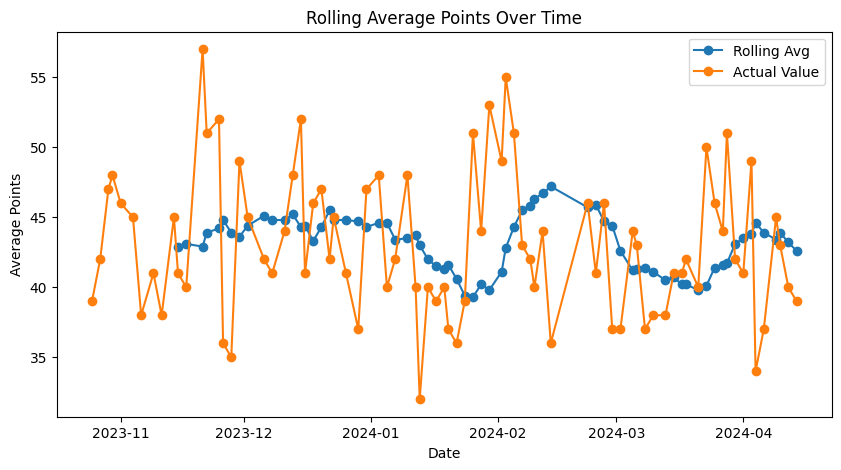

5.693453843377205

In [173]:
rmse_10 = rollingAvg(0, 'FGM', 10)
rmse_10

## Feature Selection / Feature Importance 

In [45]:
all_stats_cleaned.columns

Index(['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_DATE', 'HOME',
       'OPPONENT_ID', 'WIN', 'OPPONENT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'SEASON_YEAR'],
      dtype='object')